In [1]:
import numpy as np
from numpy import sin, cos
import cv2
import time
from math import pi
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
max_value = 255
max_value_H = 360 // 2

H_scale = 255/360.0 #H values span from 0-360
S_V_scale = 255/100.0 #S and V values span from 0-100
    
    #CHANGE THESE HSV VALUES
H_low = 80
S_low = 23
V_low = 50
H_high = 150
S_high = 100
V_high = 100

#Use HSV Color Picker values and scale to 0-255 range
red_lower = (int(H_low*H_scale), int(S_low*S_V_scale), int(V_low*S_V_scale))
red_upper = (int(H_high*H_scale), int(S_high*S_V_scale), int(V_high*S_V_scale))
window_capture_name = 'Video Capture'
window_detection_name = 'Object Detection'
low_H_name = 'Low H'
low_S_name = 'Low S'
low_V_name = 'Low V'
high_H_name = 'High H'
high_S_name = 'High S'
high_V_name = 'High V'

#red_lower = cv2.cvtColor([[[186,128,112]]],cv2.COLOR_RGB2HSV)
#red_upper = cv2.cvtColor([[[159,73,35]]],cv2.COLOR_RGB2HSV)
#red_lower = (0, .45*255, .55*255)
#red_upper = (50, 1*255, .7*255)

In [3]:

def rotate(ROT, x):
    rotx = np.array(ROT[0])
    roty = np.array(ROT[1])
    rotz = np.array(ROT[2])
    
    transx = np.array(ROT[3])
    transy = np.array(ROT[4])
    transz = np.array(ROT[5])
    
    rotx = np.array([[1,0,0], [0, cos(rotx), -sin(rotx)], [0, sin(rotx), cos(rotx)]])
    rotx = np.array(rotx)
    roty = np.array([[cos(roty), 0, sin(roty)], [0, 1, 0], [-sin(roty), 0, cos(roty)]])
    roty = np.array(roty)
    rotz = np.array([[cos(rotz), -sin(rotz), 0], [sin(rotz), cos(rotz), 0], [0, 0, 1]])
    rotz = np.array(rotz)
    
    rot = np.dot(rotx, roty)
    rot = np.dot(rot, rotz);
    
    rot = np.hstack((rot,np.array([[transx], [transy], [transz]])))
    rot = np.vstack((rot,np.array([0, 0, 0, 1])))
    return np.dot(rot, x)


def on_low_H_thresh_trackbar(val):
    global low_H
    global high_H
    low_H = val
    low_H = min(high_H-1, low_H)
    cv2.setTrackbarPos(low_H_name, window_detection_name, low_H)


def on_high_H_thresh_trackbar(val):
    global low_H
    global high_H
    high_H = val
    high_H = max(high_H, low_H+1)
    cv2.setTrackbarPos(high_H_name, window_detection_name, high_H)


def on_low_S_thresh_trackbar(val):
    global low_S
    global high_S
    low_S = val
    low_S = min(high_S-1, low_S)
    cv2.setTrackbarPos(low_S_name, window_detection_name, low_S)


def on_high_S_thresh_trackbar(val):
    global low_S
    global high_S
    high_S = val
    high_S = max(high_S, low_S+1)
    cv2.setTrackbarPos(high_S_name, window_detection_name, high_S)


def on_low_V_thresh_trackbar(val):
    global low_V
    global high_V
    low_V = val
    low_V = min(high_V-1, low_V)
    cv2.setTrackbarPos(low_V_name, window_detection_name, low_V)


def on_high_V_thresh_trackbar(val):
    global low_V
    global high_V
    high_V = val
    high_V = max(high_V, low_V+1)
    cv2.setTrackbarPos(high_V_name, window_detection_name, high_V)

In [4]:
def track(frame):
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, red_lower, red_upper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    cnts, trash = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    center = None

    if len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c) 
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

        if radius > 15:
            cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
            xoffset = int(center[0])
            yoffset = int(center[1])
        else:
            xoffset = 0
            yoffset = 0
    else:
        xoffset = 0
        yoffset = 0
    #cv2.imshow('image',frame)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    return radius

In [5]:
path = 'C:/Users/madis/images/rgb/set2'
folder = os.fsencode(path)
r = []
d = []

for file in os.listdir(folder):
    filename = os.fsdecode(file)
    filepath = os.path.join(path, filename)
    if filename.endswith( ('.png') ): # whatever file types you're using...
        img = cv2.imread(filepath)
        dist = int(filename.split('_')[0])
        radius = track(img)
        r.append(radius)
        d.append(dist)
        #print(filename)


13_1_color.png
13_2_color.png
14_1_Color.png
14_2_Color.png
14_3_Color.png
15_1_Color.png
15_2_Color.png
15_3_Color.png

In [6]:
def equation(d, r, degree):
    coeff = np.polyfit(d, r, degree)
    x = np.linspace(0, 20, 100)
    y = np.zeros(len(x))
    for i in range(len(coeff)):
        y += np.power(x, degree - i)*coeff[i]
    return x, y

In [7]:
def linear(x, a, b):
    return a*x + b

In [8]:
def inverse(x, a, b):
    return a/x + b

In [9]:
def parabolic(x, a0, a1, a2):
    return a2*np.power(x, 2) + a1 * x + a0

In [10]:
def exponential(x, a, b, c):
    return a * np.exp(-b*x) + c

In [11]:
def f(x,a,b,c, d):
    return a*np.exp(-b*(x+d))+c

In [12]:
threshhold_height = 2
small_r = []
small_d = []
big_r = []
big_d = []
for i in range(len(d)):
    if d[i] > threshhold_height:
        big_r.append(r[i])
        big_d.append(d[i])
    else:
        small_r.append(r[i])
        small_d.append(d[i])
print(small_r, small_d, big_r, big_d)

[97.22252655029297, 102.8847427368164, 83.65998840332031, 78.64338684082031, 81.66104888916016, 69.10762023925781, 69.40878295898438, 71.45115661621094] [0, 0, 1, 1, 1, 2, 2, 2] [31.31484603881836, 31.27938461303711, 29.410982131958008, 29.15485954284668, 29.1549072265625, 29.137826919555664, 27.726303100585938, 27.756967544555664, 24.382469177246094, 26.100866317749023, 26.239500045776367, 25.935115814208984, 24.654577255249023, 24.48301124572754, 23.235130310058594, 23.197742462158203, 58.08707046508789, 57.692195892333984, 61.08119583129883, 52.23574447631836, 52.65745544433594, 52.562095642089844, 47.107295989990234, 48.07514572143555, 47.8775520324707, 42.93614196777344, 42.60533905029297, 43.65288162231445, 36.866668701171875, 39.43621826171875, 39.176719665527344, 36.05481719970703, 35.61601638793945, 34.176475524902344, 31.48780059814453, 30.40719985961914, 33.842864990234375] [10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 15, 15, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7

[ 1.44511277e+01 -2.57330071e-01  1.13018205e-03]


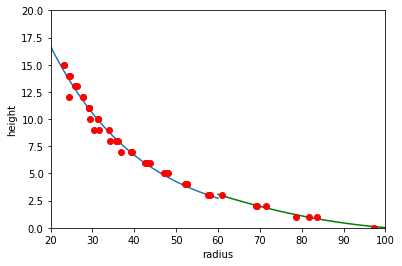

In [13]:
x = np.linspace(0, 100, 1000)
#popt1, pcov1 = curve_fit(linear, r, d)
#popt2, pcov2 = curve_fit(parabolic, r, d)
#popt3, pcov3 = curve_fit(exponential, r, d)
popt4, pcov4 = curve_fit(linear, small_r, small_d)
popt5, pcov5 = curve_fit(linear, big_r, big_d)
popt6, pcov6 = curve_fit(parabolic, small_r, small_d)
popt7, pcov7 = curve_fit(parabolic, big_r, big_d)

#plt.plot(x, linear(x, *popt4), 'r-')

x1 = np.linspace(0, 60, 100)
x2 = np.linspace(60, 100, 100)
plt.plot(x2, parabolic(x2, *popt6), 'g-')
#plt.plot(x, linear(x, *popt5), 'r-')
#plt.plot(x, parabolic(x, *popt7), 'g-')


plt.plot(x1, f(x1,13.16154266,  0.04618347, 0.10378283, -25))

print(popt6)

plt.plot(r, d, 'ro')
plt.xlabel('radius')
plt.ylabel('height')
plt.ylim((0, 20))
plt.xlim((20, 100))
plt.show()

[13.16154266  0.04618347  0.10378283]


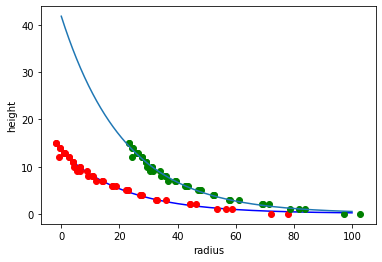

In [80]:
x = np.linspace(0, 100, 1000)
x_shifted = np.linspace(25, 195, 1000)
r_prime = [i - 25 for i in r]

popt3, pcov3 = curve_fit(exponential, r_prime, d)
#x_prime = [a + 25 for a in x]
plt.plot(x, exponential(x, *popt3), 'b-')
print(popt3)
             
#x, y = equation(d, r, 2)
plt.plot(r_prime, d, 'ro')
plt.plot(r, d, 'go')

plt.plot(x, f(x,13.16154266,  0.04618347, 0.10378283, -25))

#plt.plot(x_shifted, y, 'y')
#plt.plot(x, 4.98794026*np.exp(-0.08947573*(x-25))+.07551643, 'b')
#plt.plot(x, y, 'g')
plt.xlabel('radius')
plt.ylabel('height')
plt.show()